# Image compression for storage and Retrieval

#### This coded as a part of Image use case Hackathon

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import pickle
import cv2 as cv
import zipfile 
from zipfile import ZipFile
import glob
from pathlib import Path
from IPython.display import Image

In [2]:
#method declarations
def get_images_location_recursive(tree, images):
    
    tree = glob.glob(tree + "*")   
    
    for leaf in tree:
        
        filename, file_extension = os.path.splitext(leaf)
        
        if(file_extension == ""):
            
            get_images_location_recursive(leaf + "/", images)
        else:
            images.append(leaf)
    

def perform_image_compression(img_path):

    img = cv.imread(img_path, cv.IMREAD_UNCHANGED) # read img
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) # transform to grey scale
    thresh = 200 # binary threshold
    
    img = cv.threshold(img, thresh, 255, cv.THRESH_BINARY)[1] # transform to binary 
    df_img = pd.DataFrame(img)    
    flatten_img = df_img.to_numpy().flatten()  
    
    positions = [px for px in range(len(flatten_img)) if flatten_img[px] != 255] # save black pixels positions
    derivatives = [positions[i+1]-positions[i] for i in range(len(positions)-1)] # save black pixels positions derivatives
    
    derivatives.append(df_img.size) # size
    derivatives.append(df_img.shape[1]) # cols_number
    derivatives.append(positions[0]) # initial_position

    path, _  = os.path.splitext(img_path)
    compress_path = os.path.join(os.path.dirname(img_path),"compressed")
    if not os.path.exists(compress_path):
        os.makedirs(compress_path)
    path = os.path.join(compress_path,Path(img_path).stem)
    
    with open(path + '_compressed_binary.bin', 'wb') as f:  
        pickle.dump(derivatives, f)
    
    zipObj = ZipFile(path + '_compressed_binary' + '.zip', 'w', zipfile.ZIP_DEFLATED)  
    zipObj.write(path + '_compressed_binary.bin')
    zipObj.close()
    
    os.remove(path +'_compressed_binary.bin')
    
    
def perform_image_decompression(img_path):
    
    path, name  = os.path.split(img_path)
    
    img_path = path + "/" + name
    
    with ZipFile(img_path, 'r') as zipObj:
        listOfFileNames = zipObj.namelist()
        zipObj.extract(listOfFileNames[0], path)
    
    images = []
    get_images_location_recursive(path + '/home/*', images)
    
    with open(images[0], 'rb') as file:
        derivatives = pickle.load(file)
    
    derivatives = derivatives[::-1]  
    initial_positions = derivatives.pop(0)
    cols_number = derivatives.pop(0)
    size = derivatives.pop(0)
    derivatives = derivatives[::-1]
    
    positions=[]
    positions.append(initial_positions)
    
    for i in range(len(derivatives)):
        positions.append(positions[i] + derivatives[i])
        
    flatten_decompresion_img = size*[255]
    
    for position in positions:
        flatten_decompresion_img[position] = 0
    
    flatten_decompresion_img = np.array(flatten_decompresion_img)
    decompression_img = flatten_decompresion_img.reshape((int(size/cols_number), int(cols_number)))
    
    print(path)
    cv.imwrite(path + '/reconstructed_done.jpg', decompression_img)
    
    shutil.rmtree(path + '/home')

In [3]:
input_image = '/home/ustuser/official/AIBeta/smartvision2021/hackathon/image/carlos/OneDrive_1_20-6-2022/AccountOpeningForms/01.png'
perform_image_compression(input_image)

Input File Size:- 541728


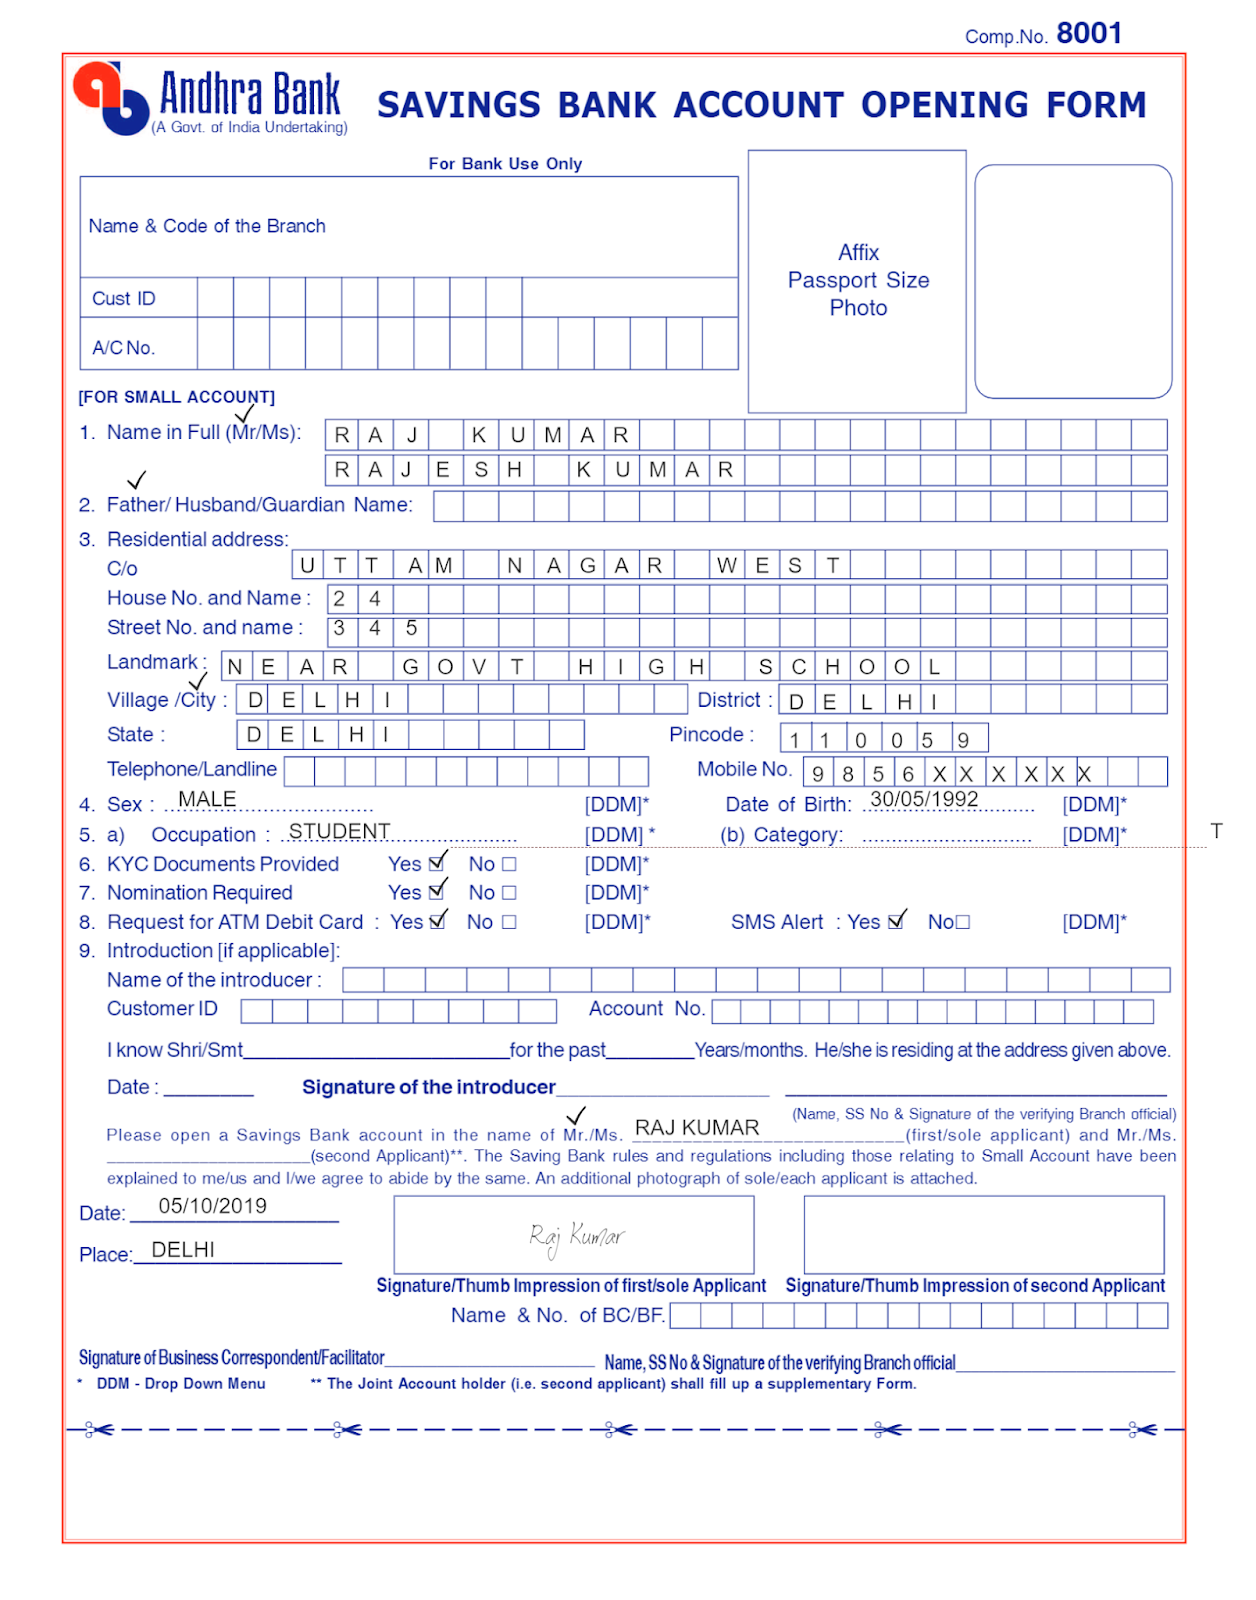

In [4]:
#input image details
pil_img = Image(filename=input_image)
print("Input File Size:-",Path(input_image).stat().st_size)
display(pil_img)

In [15]:
# compressed Path 
out_path, _  = os.path.splitext(input_image)
compress_path = os.path.join(os.path.dirname(input_image),"compressed")
file_name = os.path.join(compress_path,Path(input_image).stem)
compressed_path = os.path.join(compress_path,file_name + '_compressed_binary.zip')
compressed_path

'/home/ustuser/official/AIBeta/smartvision2021/hackathon/image/carlos/OneDrive_1_20-6-2022/AccountOpeningForms/compressed/01_compressed_binary.zip'

In [17]:
#output compressed image details
print("Compressed File Size:-",Path(compressed_path).stat().st_size)

Compressed File Size:- 36654


In [18]:
#decompress image
reconstructed_image = perform_image_decompression(compressed_path)

/home/ustuser/official/AIBeta/smartvision2021/hackathon/image/carlos/OneDrive_1_20-6-2022/AccountOpeningForms/compressed


In [20]:
recons_image_path = os.path.join(compress_path,"reconstructed_done.jpg")
print("DeCompressed File Size:-",Path(recons_image_path).stat().st_size)

DeCompressed File Size:- 520893


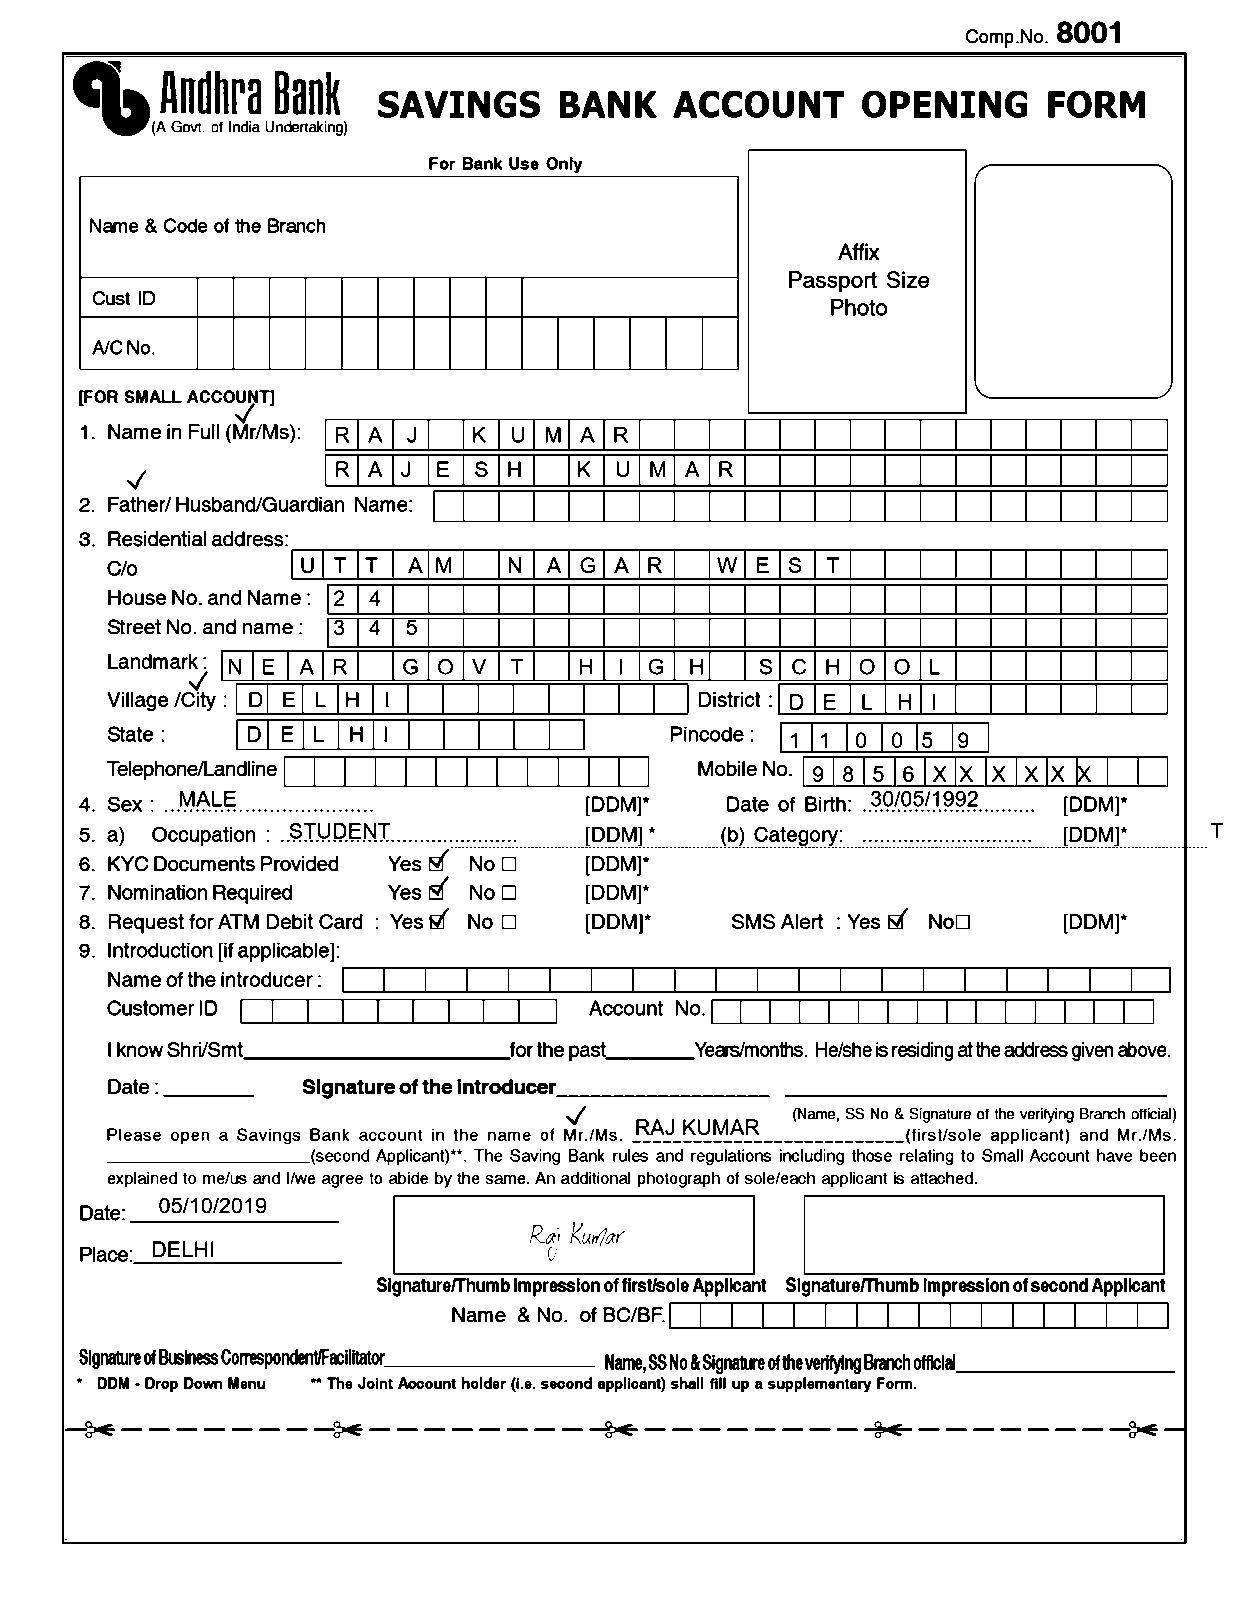

In [23]:
## Reconstructed image
pil_img = Image(filename=recons_image_path)
display(pil_img)

In [22]:
'''
Criteria:-
    Image will to be converted into Binary(Gray scale)
    Reconstructed Image will be reproduced in Gray scale only
    Efficient in compressing.
    Latency time is neglegible to store and retrieve.
NOTES:-
    Input Image             :- 541728 bytes
    Compressed image size   :- 36654 bytes
    Decompressed image Size :- 520893 bytes
    Compression %           :- 93.24% Compressed
'''

'\nNOTES:-\n    Compression % :-\n    Decompression/Reconstruction Accuracy % :- 96%\n    \n'